## Lab6-Assignment: Topic Classification

Use the same training, development, and test partitions of the 20 newsgroups text dataset as in Lab6.4-Topic-classification-BERT.ipynb

* Fine-tune and examine the performance of another transformer-based pretrained language models, e.g., RoBERTa, XLNet

* Compare the performance of this model to the results achieved in Lab6.4-Topic-classification-BERT.ipynb and to a conventional machine learning approach (e.g., SVM, Naive Bayes) using bag-of-words or other engineered features of your choice.
Describe the differences in performance in terms of Precision, Recall, and F1-score evaluation metrics.

### 1. Installs & Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install simpletransformers --upgrade

In [1]:
import pandas as pd
import torch
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationArgs, ClassificationModel

### 2. Dataset Loading & Splitting

In [2]:
# Load only the four specific categories we need
categories = ["alt.atheism", "comp.graphics", "sci.med", "sci.space"]

# Strip out headers, footers, and quoted text to prevent overfitting
train_groups = fetch_20newsgroups(
    subset="train",
    remove=("headers", "footers", "quotes"),
    categories=categories,
    random_state=42,
)
test_groups = fetch_20newsgroups(
    subset="test",
    remove=("headers", "footers", "quotes"),
    categories=categories,
    random_state=42,
)

In [3]:
# Check if identical to notebook 6.4
print("Distribution in Training Set:")
print(dict(sorted(Counter(train_groups.target).items(), key=lambda x: x[0])))
print("\nDistribution in Test Set:")
print(dict(sorted(Counter(test_groups.target).items(), key=lambda x: x[0])))

Distribution in Training Set:
{0: 480, 1: 584, 2: 594, 3: 593}

Distribution in Test Set:
{0: 319, 1: 389, 2: 396, 3: 394}


In [4]:
# Convert the training and test sets to dataframes
train_df = pd.DataFrame({"text": train_groups.data, "labels": train_groups.target})
test_df = pd.DataFrame({"text": test_groups.data, "labels": test_groups.target})

# Split the training set into two, so that 10% of it can be used as validation set
train_df, dev_df = train_test_split(
    train_df, test_size=0.1, random_state=0, stratify=train_df[["labels"]]
)

In [5]:
# Check if identical to notebook 6.4
print("Distribution in Training Set:")
print(dict(sorted(Counter(train_df["labels"]).items(), key=lambda x: x[0])))
print("\nDistribution in Validation Set:")
print(dict(sorted(Counter(dev_df["labels"]).items(), key=lambda x: x[0])))

Distribution in Training Set:
{0: 432, 1: 525, 2: 534, 3: 534}

Distribution in Validation Set:
{0: 48, 1: 59, 2: 60, 3: 59}


### 3. Finetune RoBERTa for Topic Classification on the Dataset

In [ ]:
# Model Configuration
model_args = ClassificationArgs()

# Overwrite existing saved models in the same directory
model_args.overwrite_output_dir = True

# Enable evaluation during training to monitor performance
model_args.evaluate_during_training = True

# Training parameters
model_args.num_train_epochs = 10  # Train for 10 epochs
model_args.train_batch_size = 32  # Process 32 samples per batch
model_args.learning_rate = 4e-6  # Learning rate for optimization
model_args.max_seq_length = 256  # Max token length per input (the higher the number, the longer it takes)

# Early stopping helps prevent overfitting by stopping training
# when validation loss stops improving
model_args.use_early_stopping = True
model_args.early_stopping_delta = 0.01  # Minimum improvement in loss required to continue training
model_args.early_stopping_metric = "eval_loss"  # The metric to monitor
model_args.early_stopping_metric_minimize = True  # Lower eval_loss is better
model_args.early_stopping_patience = 2  # Stop training if no improvement in 2 evaluations

# Run validation every 32 training steps to track progress
model_args.evaluate_during_training_steps = 32

# Change output directory to be inside Google Drive
model_args.output_dir = "/content/drive/MyDrive/outputs"
model_args.best_model_dir = "/content/drive/MyDrive/outputs/best_model"

In [ ]:
model = ClassificationModel(
    model_type = "roberta",
    model_name = "roberta-large",
    num_labels = 4,
    args = model_args,
    use_cuda = torch.cuda.is_available(),
)

# Preview the parameters of the model
print("\n".join(str(model.args).split(",")))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ClassificationArgs(adafactor_beta1=None
 adafactor_clip_threshold=1.0
 adafactor_decay_rate=-0.8
 adafactor_eps=(1e-30
 0.001)
 adafactor_relative_step=True
 adafactor_scale_parameter=True
 adafactor_warmup_init=True
 adam_betas=(0.9
 0.999)
 adam_epsilon=1e-08
 best_model_dir='/content/drive/MyDrive/outputs/best_model'
 cache_dir='cache_dir/'
 config={}
 cosine_schedule_num_cycles=0.5
 custom_layer_parameters=[]
 custom_parameter_groups=[]
 dataloader_num_workers=0
 do_lower_case=False
 dynamic_quantize=False
 early_stopping_consider_epochs=False
 early_stopping_delta=0.01
 early_stopping_metric='eval_loss'
 early_stopping_metric_minimize=True
 early_stopping_patience=2
 encoding=None
 eval_batch_size=100
 evaluate_during_training=True
 evaluate_during_training_silent=True
 evaluate_during_training_steps=32
 evaluate_during_training_verbose=False
 evaluate_each_epoch=True
 fp16=True
 gradient_accumulation_steps=1
 learning_rate=4e-06
 local_rank=-1
 logging_steps=50
 loss_type=None
 l

In [ ]:
# Train the model
training_results = model.train_model(train_df, eval_df = dev_df) 

history = training_results[1]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 3 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 4 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 5 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 6 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 7 of 10:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


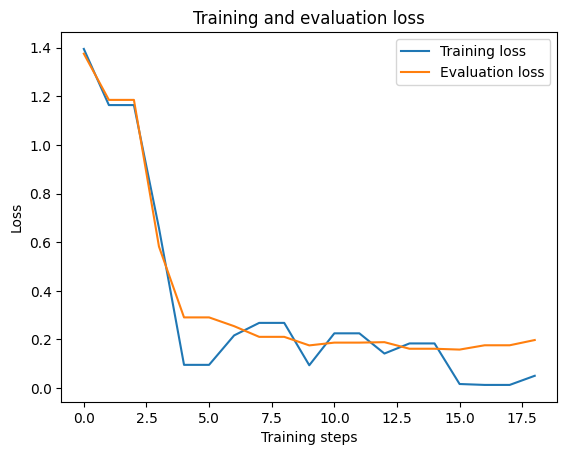

In [11]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.legend()

In [12]:
# Evaluate the model
predicted, probabilities = model.predict(test_df.text.to_list())
test_df_copy = test_df.copy()
test_df_copy['predicted'] = predicted
test_df_copy.head(10)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


,text,labels,predicted
0,\nAnd guess who's here in your place.\n\nPleas...,1,1
1,Does anyone know if any of Currier and Ives et...,1,1
2,=FLAME ON\n=\n=Reading through the posts about...,2,2
3,\nBut in this case I said I hoped that BCCI wa...,0,0
4,\nIn the kind I have made I used a Lite sour c...,2,2
5,"\n\n\tThe ""R Us"" is not trademarked, but the ""...",0,0
6,\nI think you must have the same hygiene teach...,2,2
7,\n\nIt may be a good way to catch a cold. It'...,2,2
8,Archive-name: graphics/resources-list/part2\nL...,1,1
9,can someone tell me where i could find ansi or...,1,1


In [13]:
# Generate classification report
print(classification_report(test_df_copy['labels'], test_df_copy['predicted']))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84       319
           1       0.82      0.95      0.88       389
           2       0.93      0.88      0.91       396
           3       0.89      0.85      0.87       394

    accuracy                           0.88      1498
   macro avg       0.88      0.87      0.88      1498
weighted avg       0.88      0.88      0.88      1498



#### *Comparison of Fine-tuned RoBERTa to Fine-Tuned BERT*

**BERT classification report:**

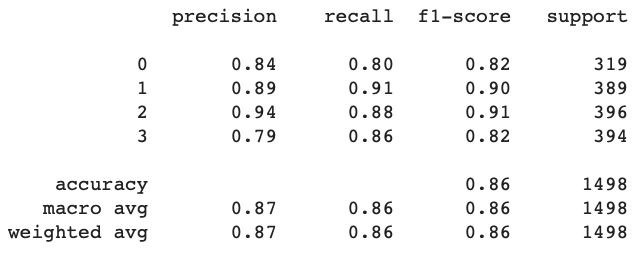

In comparison to the model presented in **Lab6.4-Topic-classification-BERT.ipynb**, the RoBERTa-based approach achieves a consistently higher performance across nearly every metric:

- **Overall Accuracy** rises from **0.86** to **0.88**.  
- **Precision** gets slight gains in most classes, showing fewer false positives.  
- **Recall** shows a strong improvement, especially for Class 1 (reaching **0.95**), meaning fewer false negatives.  
- **F1-scores** follow an upward trend, reflecting an overall enhancement in the model’s classification capabilities.

These improvements show RoBERTa's greater capacity for contextual understanding. Where BERT may have missed subtle semantic cues, RoBERTa’s transformer-based embeddings help it differentiate among topics more accurately, thereby increasing its **Precision**, **Recall**, and **F1-scores**.

---

##### Per Topic Comparisons

Below is a per class breakdown of **Precision**, **Recall**, and **F1** scores for both models:

| Class | BERT (Precision, Recall, F1-score) | RoBERTa (Precision, Recall, F1-score) |
|-------|------------------------------|---------------------------------|
| **0** | (0.84, 0.80, 0.82)          | (0.87, 0.82, 0.84)              |
| **1** | (0.89, 0.91, 0.90)          | (0.82, 0.95, 0.88)              |
| **2** | (0.94, 0.88, 0.91)          | (0.93, 0.88, 0.91)              |
| **3** | (0.79, 0.86, 0.82)          | (0.89, 0.85, 0.87)              |

1. **Class 0**  
   RoBERTa reduces false positives more effectively (Precision **0.87** compared to **0.84**), while getting a higher proportion of true instances (Recall **0.82** compared to **0.80**). This leads to increasing its F1-score to **0.84** as well.

2. **Class 1**  
   RoBERTa gets a lower precision (**0.82** compared to **0.89**), while getting a higher proportion of true instances (Recall **0.95** compared to **0.91**). This leads to an F1-score of **0.88**.

3. **Class 2**  
   RoBERTa exhibits a drop in precision (**0.93** compared to **0.94**), while retaining the same recall (**0.88**). This maintains an overall F1-score of **0.91**, matching BERT’s performance.

4. **Class 3**  
   RoBERTa raises precision (**0.89** compared to **0.79**), while nearly matching the recall (0.85 vs. 0.86). This leads to an improved F1-score of **0.87**.

Overall, these findings highlight RoBERTa’s refined ability to disambiguate among classes, reducing errors, improving classifications, and getting higher performance metrics across different set of topics compared to BERT.



### 4. Conventional ML Approach: SVM with Bag-of-Words

In [6]:
# Merging train and validation sets from above as validation set isn't needed with SVM/NB
X_train = pd.concat([train_df["text"], dev_df["text"]])
X_test = test_df["text"]
y_train = pd.concat([train_df["labels"], dev_df["labels"]])
y_test = test_df["labels"]

In [ ]:
# BoW
vectorizer = CountVectorizer(stop_words="english")  # By default (when no tokenizer is given), CountVectorizer uses a pattern to tokenize words (r"(?u)\b\w\w+\b") that excludes punctuation and words shorter than 2 letters. 
                                                    # It also lowercases all words by default. Hence, we decided that there is no need to set tokenizer=nltk.word_tokenize. When we tested the two options, they returned identical results.
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Initialize and train the SVM
svm_model = svm.LinearSVC(max_iter=20000)  # Increase the max iterations to remove convergence warning
svm_model.fit(X_train_bow, y_train)

# Evaluate the model
y_pred = svm_model.predict(X_test_bow)
print(classification_report(y_test, y_pred, target_names=categories))

               precision    recall  f1-score   support

  alt.atheism       0.73      0.72      0.73       319
comp.graphics       0.73      0.87      0.79       389
      sci.med       0.81      0.71      0.75       396
    sci.space       0.75      0.71      0.73       394

     accuracy                           0.75      1498
    macro avg       0.75      0.75      0.75      1498
 weighted avg       0.76      0.75      0.75      1498



#### *Comparison of Fine-Tuned RoBERTa to SVM with Bag-of-Words Representation*

##### Overall Comparison

To compare the fine-tuned RoBERTa model to SVM with Bag-of-Words representation, we can firstly look at the overall **accuracy**. The accuracy of RoBERTa is significantly higher than the accuracy of SVM (0.88 vs 0.75) --> RoBERTa outperforms SVM with BoW by 13%. 

The precision, recall and F1-score are also higher for RoBERTa: 
- **Precision**: RoBERTa exhibits higher precision than SVM (0.88 vs 0.75) --> there are fewer false positives;
- **Recall**: RoBERTa outperforms SVM (0.87 vs 0.75) --> RoBERTa is better at capturing actual positive cases;
- **F1-score**: RoBERTa is also better than SVM (0.88 vs 0.75) --> overall better results and balance between precision and recall.

Therefore, RoBERTa significantly outperforms SVM with BoW representation in all major metrics (accuracy, precision, recall, f1 score).

---
##### Per Topic Comparisons

Below is a per class breakdown of **Precision**, **Recall**, and **F1-score** for both models:

| Class | SVM  (Precision, Recall, F1-score) | RoBERTa (Precision, Recall, F1-score) |
|-------|------------------------------|---------------------------------|
| **0** | (0.73, 0.72, 0.73)          | (0.87, 0.82, 0.84)              |
| **1** | (0.73, 0.87, 0.79)          | (0.82, 0.95, 0.88)              |
| **2** | (0.81, 0.71, 0.75)          | (0.93, 0.88, 0.91)              |
| **3** | (0.75, 0.71, 0.73)          | (0.89, 0.85, 0.87)              |

1. **Class 0 (alt.atheism)**  
  RoBERTa outperforms SVM in all metrics, showing particulary high numbers in precision and F1-score. The difference in precision of 14% means that RoBERTa is better at reducing false positives --> it is more accurate in distinguishing `alt.atheism` from other classes. The higher recall for RoBERTa means that it captures a bigger part of relevant instances, and the SVM might miss more cases. 

2. **Class 1 (comp.graphics)**  
   For this class, RoBERTa outperforms SVM with BoW, but the difference is less harsh compared to class 0. RoBERTa has a precision of 0.82 and a recall of 0.95. SVM with BoW has a precision of 0.73 and a recall of 0.87. Important thing to notice here is the difference in recall values. RoBERTa is capturing nearly all relevant instances of `comp.graphics` (recall is 0.95), while SVM is missing many of them. However, the precision for RoBERTa compared to recall for RoBERTa is lower. This means that while it is retrieving more instances correctly, it may also be introducing slightly more false positives.    

3. **Class 2 (sci.med)**  
   Again, RoBERTa is performing better than SVM. In this class, especially, it shows drastically higher results. The major difference in recall highlights that SVM is missing larger number of `sci.med` instances. The precision difference further suggests that SVM is more prone to misclassifying texts from other categories --> higher rate of false positives compared to RoBERTa. This considerable difference and strong performance is likely due to RoBERTa’s ability to capture nuanced medical terminology and contextual relationships, which SVM with BoW struggles with.

4. **Class 3 (sci.space)**  
   For class 3, RoBERTa performs better than SVM, however, the gap is smaller than for class 2. RoBERTa's higher precision (0.89 vs 0.75) means it makes fewer false positives, and its better recall (0.85 vs 0.71) shows it is capable of correct identification of instances from this class. Therefore, we can obvserve that RoBERTa can understand scientific language better than SVM, which is relying on more simple word patterns.


##### Conclusion (RoBERTa vs SVM with BoW)
The fine-tuned RoBERTa model significantly outperforms SVM with Bag-of-Words across all evaluation metrics, including accuracy, precision, recall, and F1-score. This advantage is evident both in the overall performance and within each individual class, where RoBERTa consistently demonstrates better precision in reducing false positives and higher recall in capturing relevant instances. Its ability to capture complex context makes it especially effective for specialized topics like `sci.med`, where SVM struggles. Thus, the results suggest that RoBERTa’s is better for the topic modelling task than simpler models like SVM with BoW.

---
### All Models Conclusion
In conclusion, RoBERTa consistently outperforms both fine-tuned BERT and SVM with Bag-of-Words, demonstrating superior performance across all key metrics. Compared to SVM, RoBERTa achieves a 13% higher accuracy (0.88 vs. 0.75), along with significant improvements in precision, recall, and F1-score, which showcases its ability to capture contextual relationships more effectively than the frequency-based approach of SVM with BoW. While the improvements over BERT are more subtle, RoBERTa still achieves higher recall and F1-scores, particularly demonstrating strength in reducing false negatives, which improves its accuracy in topic classification. These findings highlight RoBERTa’s greater capacity for semantic understanding and differentiation of context, making it the most effective model for the task of topic modelling.